## Adapted from Lesson 2. Open, Plot and Explore Raster Data with Python
### By Leah Wasser, Chris Holdgraf, Martha Morrissey
#### https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/fundamentals-raster-data/open-lidar-raster-python/

In this lesson you will learn more about working with lidar derived raster data that represents both terrain / elevation data (elevation of the earth’s surface), and surface elevation (elevation at the tops of trees, buildings etc above the earth’s surface). If you want to read more about how lidar data are used to derive raster based surface models, you can check out this chapter on lidar remote sensing data and the various raster data products derived from lidar data: https://www.earthdatascience.org/courses/use-data-open-source-python/data-stories/what-is-lidar-data/ 

In [6]:
# Import necessary packages
import os
import matplotlib.pyplot as plt
import seaborn as sns
# Use geopandas for vector data and rasterio for raster data
import geopandas as gpd
import rasterio as rio
# Plotting extent is used to plot raster & vector data together
from rasterio.plot import plotting_extent

import earthpy as et
import earthpy.plot as ep

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="white")

In [7]:
# Get data and set working directory
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

Below, you define the path to a lidar derived digital elevation model (DEM) that was created using NEON (the National Ecological Observatory Network) data. Data Tip: DEM’s are also sometimes referred to as DTM (Digital Terrain Model or DTM). You can learn more about the 3 lidar derived elevation data types:https://www.earthdatascience.org/courses/use-data-open-source-python/data-stories/what-is-lidar-data/lidar-chm-dem-dsm/

In [9]:
# Define relative path to file
dem_pre_path = os.path.join("colorado-flood",
                            "spatial",
                            "boulder-leehill-rd",
                            "pre-flood",
                            "lidar",
                            "pre_DTM.tif")

# Open the file using a context manager ("with rio.open" statement)
with rio.open(dem_pre_path) as dem_src:
    dtm_pre_arr = dem_src.read(1)

You may notice that the code above used to open a raster file is a bit more complex than the code that you used to open vector files (shapefiles) with geopandas or tabular data with pandas. The with rio.open() statement creates what is called a context manager for opening files. This allows you to create a connection to the file without modifying the file itself. You can learn more about context managers in the raster data in python chapter in the earth data science intermediate textbook

### Explore Raster Data Values & Structure
Next, have a look at the data. Notice that the data structure of type() of Python object returned by rasterio is a numpy array. Numpy arrays are an efficient way to store and work with raster data in python. You will learn more about working with numpy arrays in the numpy array chapter of the introduction to earth data science textbook



In [10]:
type(dtm_pre_arr)

numpy.ndarray

In [11]:
dtm_pre_arr.shape

(2000, 4000)

When you open raster data using rasterio you are creating a numpy array. Numpy is an efficient way to work with and process raster format data. You can plot your data using earthpy plot_bands() which takes a numpy array as an input and generates a plot.

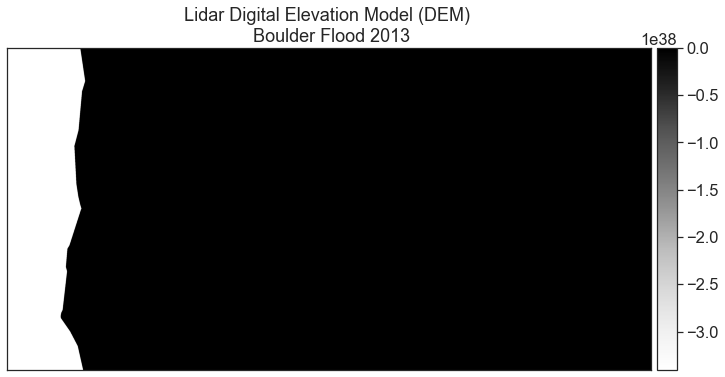

In [12]:
# Plot your data using earthpy
ep.plot_bands(dtm_pre_arr,
              title="Lidar Digital Elevation Model (DEM) \n Boulder Flood 2013",
              cmap="Greys")

plt.show()

The data above should represent terrain model data. However, the range of values is not what is expected. These data are for Boulder, Colorado where the elevation may range from 1000-3000m.

There may be some outlier values in the data that may need to be addressed. Below you check out the min and max values of the data.

In [14]:
print("the minimum raster value is: ", dtm_pre_arr.min())
print("the maximum raster value is: ", dtm_pre_arr.max())


the minimum raster value is:  -3.4028235e+38
the maximum raster value is:  2087.43


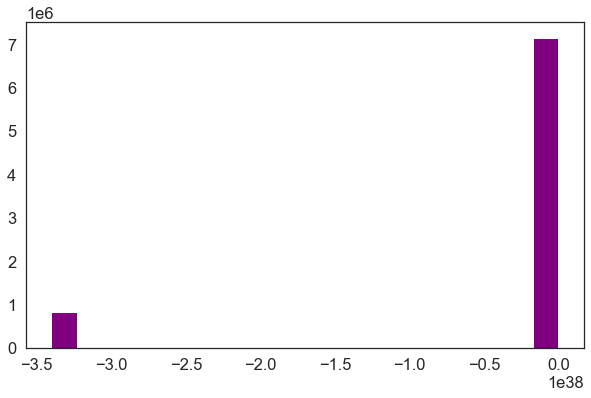

In [15]:
# A histogram can also be helpful to look at the range of values in your data
# What do you notice about the histogram below?
ep.hist(dtm_pre_arr,
        figsize=(10, 6))
plt.show()

Histogram for your lidar DTM. Notice the number of values that are below 0. This suggests that there may be no data values in the data.

### Raster Data Exploration - Min and Max Values
Looking at the minimum value of the data, there is one of two things going on that need to be fixed

there may be no data values in the data with a negative value that are skewing your plot colors
there also could be outlier data in your raster
You can explore the first option - that there are no data values by reading in the data and masking no data values using rasterio. To do this, you will use the masked=True parameter for the .read() function - like this:



In [16]:
# Read in your data and mask the no data values
with rio.open(dem_pre_path) as dem_src:
    # Masked=True will mask all no data values
    dtm_pre_arr = dem_src.read(1, masked=True)

Notice that now the minimum value looks more like an elevation value (which should most often not be negative).

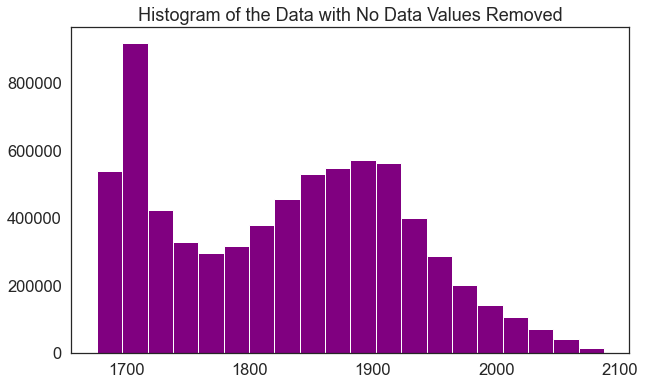

In [17]:
# A histogram can also be helpful to look at the range of values in your data
ep.hist(dtm_pre_arr,
        figsize=(10, 6),
        title="Histogram of the Data with No Data Values Removed")
plt.show()

Plot your data again to see how it looks:

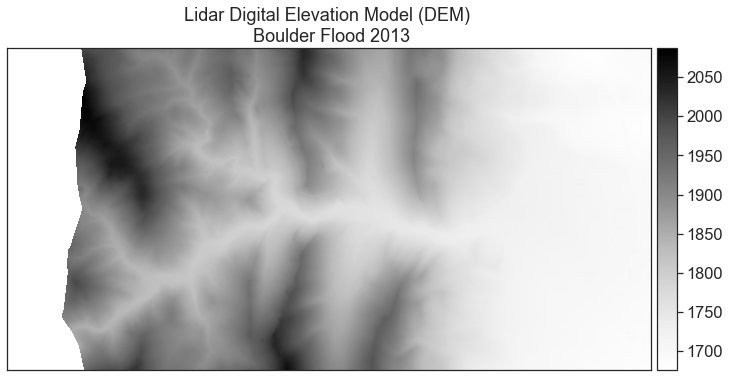

In [18]:
# Plot data using earthpy
ep.plot_bands(dtm_pre_arr,
              title="Lidar Digital Elevation Model (DEM) \n Boulder Flood 2013",
              cmap="Greys")

plt.show()
#The white area on the left is an area that we don't have data for. 

### Rasterio Reads Files into Python as Numpy Arrays
When you call src.read() above, rasterio is reading in the data as a numpy array. A numpy array is a matrix of values. Numpy arrays are an efficient structure for working with large and potentially multi-dimensional (layered) matrices.

The numpy array below is type numpy.ma.core.MaskedArray. It is a masked array because you chose to mask the no data values in your data. Masking ensures that when you plot and perform other math operations on your data, those no data values are not included in the operations.

Learn more about working with numpy arrays: https://www.earthdatascience.org/courses/intro-to-earth-data-science/scientific-data-structures-python/numpy-arrays/ 

## TASK 1:
### Look closely at the plot above. What do you think the colors and numbers represent in the plot?

### What units do the numbers represents? Double click on the text in this box to enter your answer.
#Black=higher elevation, white=no data, gray=between high elevation and low elevation

In [19]:
with rio.open(dem_pre_path) as dem_src:
    lidar_dem_im = dem_src.read(1, masked=True)

print("Numpy Array Shape:", lidar_dem_im.shape)
print("Object type:", type(lidar_dem_im))

Numpy Array Shape: (2000, 4000)
Object type: <class 'numpy.ma.core.MaskedArray'>


A numpy array does not by default store spatial information. However, your raster data is spatial - it represents a location on the earth’s surface.

You can acccess the spatial metadata within the context manager using dem_src.profile. Notice that the .profile object contains information including the no data values for your data, the shape, the file type and even the coordinate reference system. You will learn more about raster metadata in the raster metadata lesson in this chapter: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/fundamentals-raster-data/raster-metadata-in-python/

In [20]:
with rio.open(dem_pre_path) as dem_src:
    lidar_dem_im = dem_src.read(1, masked=True)
    # Create an object called lidar_dem_meta that contains the spatial metadata
    lidar_dem_meta = dem_src.profile
#.profile is how you get the metadata
lidar_dem_meta

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 4000, 'height': 2000, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(1.0, 0.0, 472000.0,
       0.0, -1.0, 4436000.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

### Context Managers to Open and Close File Connections
The steps above represent the steps you need to open and plot a raster dataset using rasterio in python. The with rio.open() statement creates what is known as a context manager. A context manager allows you to open the data and work with it. Within the context manager, Python makes a temporary connection to the file that you are trying to open.

In the example above this was a file called pre_DTM.tif.

To break this code down, the context manager has a few parts. First, it has a with statement. The with statement creates a connection to the file that you want to open. The default connection type is read only. This means that you can NOT modify that file by default. Not being able to modify the original data is a good thing because it prevents you from making unintended changes to your original data.

In [21]:
#note: to make this run, you'd need to rename 'file-path-here', we'll do this below so don't edit this code block
with rio.open(`file-path-here`) as file_src:
    dtm_pre_arr = dem_src.read(1, masked=True)

SyntaxError: invalid syntax (<ipython-input-21-7b07b81349e0>, line 2)

#### Notice that the first line of the context manager is not indented. It contains two parts

1) rio.open(): This is the code that will open a connection to your .tif file using a path you provide.
file_src: this is a rasterio reader object that you can use to read in the actual data. You can also use this object to access the metadata for the raster file.

2) The second line of your with statement

dtm_pre_arr = dem_src.read(1, masked=True)

is indented. Any code that is indented directly below the with statement will become a part of the context manager. This code has direct access to the file_src object which is you recall above is the rasterio reader object.

Opening and closing files using rasterio and context managers is efficient as it establishes a connection to the raster file rather than directly reading it into memory.

Once you are done opening and reading in the data, the context manager closes that connection to the file. This efficiently ensures that the file won’t be modified later in your code.

You can get a better understanding of how the rasterio context manager works by taking a look at what it is doing line by line. Start by looking at the dem_pre_path object. Notice that this object is a path to the file pre_DEM.tif. The context manager needs to know where the file is that you want to open with Rasterio.

In [22]:
# Look at the path to your dem_pre file
dem_pre_path

'colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DTM.tif'

Now use the dem_pre_path in the context manager to open and close your connection to the file. Notice that if you print the “src” object within the context manager (notice that the print statement is indented which is how you know that you are inside the context manager), the returl is an

open DatasetReader

The name of the reader is the path to your file. This means there is an open and active connection to the file.

In [23]:
# Opening the file with the dem_pre_path
# Notice here the src object is printed and returns an "open" DatasetReader object
with rio.open(dem_pre_path) as src:
    print(src)

<open DatasetReader name='colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DTM.tif' mode='r'>


If you print that same src object outside of the context manager, notice that it is now a closed datasetReader object. It is closed because it is being called outside of the context manager. Once the connection is closed, you can no longer access the data. This is a good thing as it protects you from inadvertently modifying the file itself!

In [24]:
# Note that the src object is now closed because it's not within the indented
# part of the context manager above
print(src)

<closed DatasetReader name='colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DTM.tif' mode='r'>


Now look at what .read() does. Below you use the context manager to both open the file and read it. See that the read() method, returns a numpy array that contains the raster cell values in your file.

In [25]:
# Open the file using a context manager and get the values as a numpy array with .read()
with rio.open(dem_pre_path) as dem_src:
    dtm_pre_arr = dem_src.read(1)

dtm_pre_arr

array([[-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6956300e+03,  1.6954199e+03,  1.6954299e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6956000e+03,  1.6955399e+03,  1.6953600e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6953800e+03,  1.6954399e+03,  1.6953700e+03],
       ...,
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6814500e+03,  1.6813900e+03,  1.6812500e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6817200e+03,  1.6815699e+03,  1.6815599e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6818900e+03,  1.6818099e+03,  1.6817400e+03]], dtype=float32)

Because you created an object within the context manager that contains those raster values as a numpy array, you can now access the data values without needing to have an open connection to your file. This ensures once again that you are not modifying your original file and that all connections to it are closed. You are now free to play with the numpy array and process your data!


In [26]:
# View numpy array of your data
dtm_pre_arr

array([[-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6956300e+03,  1.6954199e+03,  1.6954299e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6956000e+03,  1.6955399e+03,  1.6953600e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6953800e+03,  1.6954399e+03,  1.6953700e+03],
       ...,
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6814500e+03,  1.6813900e+03,  1.6812500e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6817200e+03,  1.6815699e+03,  1.6815599e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6818900e+03,  1.6818099e+03,  1.6817400e+03]], dtype=float32)

You can use the .profile attribute to create an object with metadata on your raster image. The metadata object below contains information like the coordinate reference system and size of the raster image.

In [27]:
with rio.open(dem_pre_path) as dem_src:
    # Create an object called lidar_dem_meta that contains the spatial metadata
    lidar_dem_meta = dem_src.profile

lidar_dem_meta

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 4000, 'height': 2000, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(1.0, 0.0, 472000.0,
       0.0, -1.0, 4436000.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

Finally, take a look at what the plotting_extent() function does. Note below that when you run the plotting_extent() function on your dem_pre raster image, you get the extent of the image as an output.

In [28]:
with rio.open(dem_pre_path) as dem_src:
    # Create an object called lidar_dem_plot_ext that contains the spatial metadata
    lidar_dem_plot_ext = plotting_extent(dem_src)

# This plotting extent object will be used below to ensure your data overlay correctly
lidar_dem_plot_ext

(472000.0, 476000.0, 4434000.0, 4436000.0)

### Imagery - Another Type of Raster Data
Another type of raster data that you may see is imagery. If you have used Google Maps or another mapping tool that has an imagery layer, you are looking at raster data. You can open and plot imagery data using Python as well.

Below you download and open up some NAIP data that were collected before a fire that occured close to Nederland, Colorado.

Data Tip: NAIP data is imagery collected by the United States Department of Agriculture every 2 years across the United States. Learn more about NAIP data in this chapter of the earth data science intermediate textbook: https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/intro-naip/

In [29]:
# Download NAIP data
et.data.get_data(url="https://ndownloader.figshare.com/files/23070791")


Extracted output to /Users/ryankiey/earth-analytics/data/earthpy-downloads/naip-before-after


'/Users/ryankiey/earth-analytics/data/earthpy-downloads/naip-before-after'

In [ ]:
# Create a path for the data file - notice it is a .tif file
naip_pre_fire_path = os.path.join("earthpy-downloads",
                                  "naip-before-after",
                                  "pre-fire",
                                  "crop",
                                  "m_3910505_nw_13_1_20150919_crop.tif")

naip_pre_fire_path

In [ ]:
# Open the data using rasterio
with rio.open(naip_pre_fire_path) as naip_prefire_src:
    naip_pre_fire = naip_prefire_src.read()

naip_pre_fire

Plotting imagery is a bit different because imagery is composed of multiple bands. While we won’t get into the specifics of bands and images in this lesson, you can see below that an image is composed of multiple layers of information.

You can plot each band individually as you see below using plot_bands(). Or you can plot a color image, similar to the image that your camera stores when you take a picture.

In [ ]:
# Plot each layer or band of the image separately
ep.plot_bands(naip_pre_fire, figsize=(10, 5))
plt.show()

In [ ]:
# Plot of all NAIP Data Bands using earthpy plot_bands()
# Plot color image
ep.plot_rgb(naip_pre_fire,
            title="naip data pre-fire")
plt.show()

## Task 2: Plot pre and post-fire data
### In the code below, you see a path to a NAIP dataset that was collected after the fire in Colorado. Use that path to:

### 1) Open the post fire data
### 2) Plot a color version of data using plot_rgb()

### Think outside the box: how could you quantify the change in the two images?

In [ ]:
# Add the code here to open the raster and read the numpy array inside it
# Create a path for the data file - notice it is a .tif file
naip_post_fire_path = os.path.join("earthpy-downloads",
                                   "naip-before-after",
                                   "post-fire",
                                   "crop",
                                   "m_3910505_nw_13_1_20170902_crop.tif")

naip_post_fire_path